# Logistic Regression Classifer from Scratch

Now that we have a grasp of the theory behind logistic regression, its cost function, and parameter optimization through gradient descent ("Logistic_Regression_Theory.ipynb", "Gradient_Descent_Theory.ipynb"), we can now bundle these functions into a model. Here, we'll classify hand-written digits using the MNIST dataset, which is the "hello world" of classification datasets. Loading the code from the theory tutorials...

In [1]:
import numpy as np

def sigmoid(x):
    """
    Helper function to compute the sigmoid of a given array
    
    input
    -----
    x: ndarray-like, output vector of linear function
    
    output
    -----
    s: ndarray-like, sigmoid of input"""
    
    sig = 1/(1+np.exp(-x))
    return sig

def init_wb(size, init_val=0):
    """
    Function to initialize weights vector/bias term 
    
    input
    -----
    size: int
        length of weights vector
    kind: int or float
        value to init 
        
    output
    -----
    w, b
        """
    if init_val == 0:
        w = np.zeros((size, 1))
        b = 0
    else:
        w = np.ones((size, 1)) * init_val
        b = init_val
    return w, b

def propagation(X, y, w, b):
    """
    Compute resulting cost function and gradients from
    forward propagation and backward propagation respectively
    
    input
    -----
    X: ndarray-like, training set to fit
    y: vector-like, X's corresponding target
    w: weight vector
    b: bias term
    
    output
    ------
    tuple; dw, db, cost
        dw: numeric, gradient of the weight vector
        db: numeric, gradient of the bias vector
        cost: vector-like, cost of weight, bias terms
    """
    
    samples = X.shape[1]
    
    # Forward Propagation (left to right)
    A = sigmoid(np.dot(w.T, X) + b)
    cost = -(1/samples) * np.sum(y * np.log(A) + (1 - y)*(np.log(1 - A)))
    
    # Backward Propagation (right to left)
    dw = (1/samples) * np.dot(X, (A - y).T)
    db = (1/samples) * np.sum(A - y)
    return {'dw': dw, 'db': db, 'cost':np.squeeze(cost)}

def grad_descent(X, y, w, b, n, eta):
    """
    Function running gradient descent to optimize w and b
    to minimize the cost function

    input
    -----
    X: ndarray-like, training set to fit
    y: vector-like, X's corresponding target
    w: weight vector
    b: bias term
    n: number of iterations to loop
    eta: learning rate
    
    output
    ------
    
    
    """
    costs = []
    
    for i in range(n):
        
        prop = propagation(X, y, w, b)
        dw, db, cost = prop['dw'], prop['db'], prop['cost']
        
        w  = w - (eta * dw)
        b = b - (eta * db)
        
        if i % 100 == 0:
            costs.append(cost)
    
    return {'w':w, 'dw':dw, 'b':b, 'db':db, 'costs':costs}

def prediction(X, w, b):
    """
    Predict binomial classification based on trained w, b
    
    input
    -----
    w: ndarray-like
        weights vector
    b: int or float
        bias term
    X: ndarray-like
    
    output
    -----
    y_pred: np.array
        array of predictions to corresponding X instances
        """
    samples = X.shape[1]
    y_pred = np.zeros((1, samples))
    w = w.reshape(X.shape[0], 1)
    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        # Bin probabiliites into actual predictions
        y_prob = A[0, i]
        if y_prob > 0.5:
            y_pred[:, i] = 1
        else:
            y_pred[:, i] = 0
            
    return y_pred

## Model 
Rather than build our own framework for our model, scikit-learn offers base classes and mixins for building custom models. This gives us the added benefit of harnessing the package's scoring and cross-validation features.

If the below code looks foreign to you, you may want to review the OOP tutorials to explain the inheritance/polymorphism inherent to using base classes, and overwriting the score function.

If sklearn is unfamiliar, it is a very popular machine learning framework maintained by a large community of ML developers. For our scope, there's a few simple features we'll be using that are consistent across most all of sklearn's ML algorithms. 
1. Each algorithm is passed hyperparameters to its constructor
2. After instantiation, the model fits the data by passing training data to its `fit()` method
3. The `predict()` method returns the predicted value when passed input data, given that the model has been trained
4. The `score()` method compares predicted values against true values, and is used in sklearn's cross validation functionality. 

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin

class CustomLogReg(BaseEstimator, ClassifierMixin):
    
    def __init__(self, init_params=0, n_iterations=100, eta=0.05):
        self.init_params = init_params
        self.n_iterations = n_iterations
        self.eta = eta
        
    def fit(self, X, y=None):
        self._w, self._b = init_wb(X.shape[0], init_val=self.init_params)
        gd = grad_descent(X, y, self._w, self._b, self.n_iterations, self.eta)
        self.w_ = gd['w']
        self.b_ = gd['b']
        self.dw_ = gd['dw']
        self.db_ = gd['db']
        self.cost_ = gd['costs']
        
    def predict(self, X, y=None):
        try:
            getattr(self, 'w_')
            getattr(self, 'w_')
        except:
            raise RuntimeError('Train classifier using .fit() before running .predict()')
            
        return prediction(X, self.w_, self.b_)
    
    def score(self, X, y_true=None):
        
        return((self.predict(X) == y_true).sum()) / len(y_true)

Training the model on the **right data** is equally as important as how we build the model, and this step in an ML project can be highly time consuming. From a statistical standpoint, effective sampling of data is critical to the model's future ability to generalize to unseen data. For our purposes, we'll skip this step in the workflow, and use sklearn's `datasets` class to load pre-cleaned, pre-sampled MNIST data.

At this step, it is also important to set aside a fraction of the data (~20% in this case) for validating the model. We'll use the larger portion for training, and see how well the model generalizes to the unseen data. No data snooping!

In [10]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
mnist = load_digits()

X = mnist.data

# Since LR is binomial and not multiclass,
# will encode 5's as 1's and all others 0's
y = np.array([1 if j==5 else 0 for j in mnist.target]).T

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [11]:
# Here we instantiate the classifier
clf = CustomLogReg(n_iterations=2000, eta=0.05)

# Here we fit the model
clf.fit(X_train.T, y_train)

Let's look at how our gradient descent algorithm performed in terms of our cost function

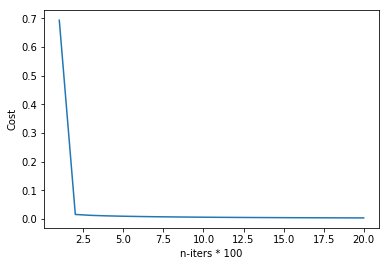

In [12]:
import matplotlib.pyplot as plt

plt.figure()

plt.plot(np.arange(1, len(clf.cost_) + 1), clf.cost_)
plt.ylabel('Cost')
plt.xlabel('n-iters * 100');

Pretty quick convergence on the minimum! If we were to continue to iterate on building this model, we could throttle back on the descent iterations to save time.

Now let's see how our model performs on predicting the training data.

In [13]:
clf.score(X_train.T, y_train)

0.9992576095025983

Near perfect score, but this alone is actually not a good measure of a machine learning algorithm. Ultimately, these models aren't valuable until they can accurately predict the target from *unseen* data. In linear models especially, overfitting can prevent generalization to new data. Let's see how the model performs on our test data.

In [14]:
clf.score(X_test.T, y_test)

0.9888888888888889

Wow! >98% accuracy! This model is good to go. But in the real world, especially in image recognition, data won't be as structured as the MNIST dataset. Say we were to get poor scores on unseen data, but high scores on training data, our model is overfitting. In that case, our next step would be to add regularization to the linear model $z$, which penalizes such overfitting.

We have a model now that can predict whether a hand written digit is five. Let's bundle this into a function.

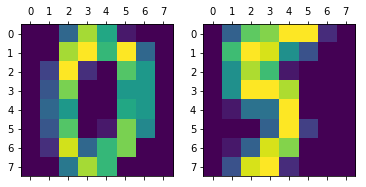

In [15]:
fig, axes = plt.subplots(1, 2)
notfive = mnist.images[y == 0][0]
five = mnist.images[y == 1][1]
axes[0].matshow(notfive)
axes[1].matshow(five);

In [32]:
def gimme_five(img):
    """
    Function to classify image of handwritten
    digit as five or not-five
    """
    flatten = img.reshape(-1, 1)
    pred = clf.predict(flatten)
    if pred == 1:
        return "It's a five!"
    elif pred == 0:
        return "Not a five"

In [33]:
gimme_five(five)

"It's a five!"

In [34]:
gimme_five(notfive)

'Not a five'

## Conclusion 
Now we have a fully functioning image classifier built from scratch. While this demo was done in a computer vision context, logistic regression also extends to defect analysis (pass/fail of wafers given I/O data), even in-situ endpoint capabilities.